In [49]:
import numpy as np

def simulate_complex_spectrum(complex_mass, resolution, chargewidth, maxcharge, noise_level, Q, F, AO, VA):
    """
    Simulate mass spectrum for a single protein complex.
    """
    mz_range = np.arange(1, 20001)
    spectrum = np.zeros_like(mz_range, dtype=float)

    MS = complex_mass
    MA = Q * MS**0.76
    ME = MS + MA
    ZA = 0.0467 * ME**0.533 + F
    TT = np.exp(-(np.arange(maxcharge) - 50)**2 / chargewidth)
    sumT = np.sum(TT)
    WC = np.zeros(maxcharge)
    DE = np.zeros_like(WC)

    for charge in range(maxcharge):
        WC[charge] = np.exp(-(charge + 1 - ZA)**2 / chargewidth) / sumT
        if ME > 0:
            DE[charge] = (1 - np.exp(-1620 * (9.1 * (charge + 1) / ME)**1.75)) * AO * VA
        else:
            DE[charge] = 0  # Set to 0 if ME is zero or negative

    WD = WC * DE

    for charge in range(1, maxcharge + 1):
        mz = ME / charge
        if mz < len(mz_range):
            lower_limit = max(1, int(mz - resolution / 10))
            upper_limit = min(len(mz_range), int(mz + resolution / 10))
            for axis in range(lower_limit, upper_limit):
                spread = np.exp(-((axis - mz)**2) / (2 * (resolution / 100)**2))
                spectrum[axis] += WD[charge - 1] * spread

    noise = np.random.normal(0, noise_level, size=spectrum.size)
    spectrum += noise

    return spectrum

def simulate_mass_spectrum(monomer_masses, interaction_matrix, resolution, chargewidth, maxcharge, noise_level, Q, F, AO, VA):
    """
    Simulate mass spectra for two proteins and their complexes based on an interaction matrix.

    Parameters:
    - monomer_masses: list of float, masses of the two protein monomers in Da
    - interaction_matrix: 2D numpy array, where (0, 0) represents no proteins, (1, 0) represents Protein A monomer, (0, 1) represents Protein B monomer, and so on
    - resolution: float, resolution of the mass spectrometer
    - chargewidth: float, width of the charge distribution
    - maxcharge: int, maximum charge state to consider
    - noise_level: float, standard deviation of Gaussian noise added to the spectrum
    - Q: float, parameter for accounting for adduct binding
    - F: float, parameter for charge state fluctuation
    - AO: float, open area of the detector
    - VA: float, accelerating voltage

    Returns:
    - mz_range: array, m/z range of the spectrum
    - normalized_spectrum: array, combined intensity values across the m/z range for all proteins and complexes, normalized against the sum of intensities
    """
    mz_range = np.arange(1, 20001)
    combined_spectrum = np.zeros_like(mz_range, dtype=float)

    for i, j in np.argwhere(interaction_matrix):
        monomer_mass_A = monomer_masses[0]
        monomer_mass_B = monomer_masses[1]
        stoich_A = i  # Stoichiometry of Protein A
        stoich_B = j  # Stoichiometry of Protein B

        complex_mass = stoich_A * monomer_mass_A + stoich_B * monomer_mass_B  # Calculate the complex mass according to equation S1
        spectrum = simulate_complex_spectrum(complex_mass, resolution, chargewidth, maxcharge, noise_level, Q, F, AO, VA)
        combined_spectrum += spectrum * interaction_matrix[i, j]  # Scale by the interaction matrix value

    # Normalize the combined spectrum against the sum of intensities
    total_intensity = np.sum(combined_spectrum)
    if total_intensity > 0:
        normalized_spectrum = combined_spectrum / total_intensity
    else:
        normalized_spectrum = combined_spectrum

    return mz_range, normalized_spectrum

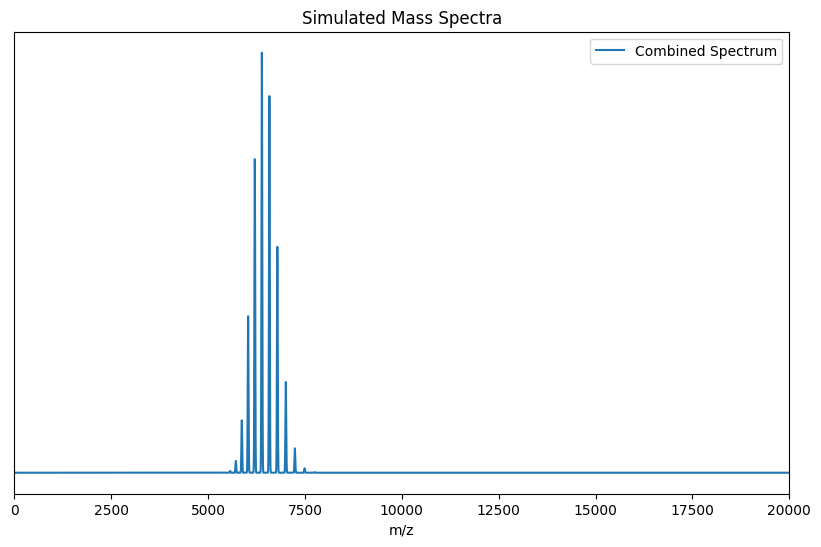

In [50]:
# Monomer masses of Protein A and Protein B
monomer_masses = [210000, 18000]

# Interaction matrix:
# 0, 0 - No proteins
# 1, 0 - Protein A monomer
# 0, 1 - Protein B monomer
# 1, 1 - Heterodimer (Protein A monomer + Protein B monomer)
# 2, 0 - Protein A dimer
# 0, 2 - Protein B dimer
# 2, 1 - Protein A dimer + Protein B monomer
# 1, 2 - Protein A monomer + Protein B dimer
# 2, 2 - Heterotetramer (Protein A dimer + Protein B dimer)
interaction_matrix = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0 , 0, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0 , 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0 , 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0 , 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0 , 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0 , 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0 , 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0 , 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0 , 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0 , 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0 , 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0 , 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0 , 0, 0, 0]
])

resolution = 1000
chargewidth = 5
maxcharge = 50
noise_level = 0.000
Q = 0.1
F = 1
AO = 1
VA = 1

mz_range, normalized_spectrum = simulate_mass_spectrum(monomer_masses, interaction_matrix, resolution, chargewidth, maxcharge, noise_level, Q, F, AO, VA)

# Plot the simulated spectrum
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(mz_range, normalized_spectrum, label='Combined Spectrum')
plt.xlabel('m/z')
plt.yticks([])  # Remove y-axis tick labels
plt.title('Simulated Mass Spectra')
plt.xlim(0, 20001)
plt.legend()
plt.show()

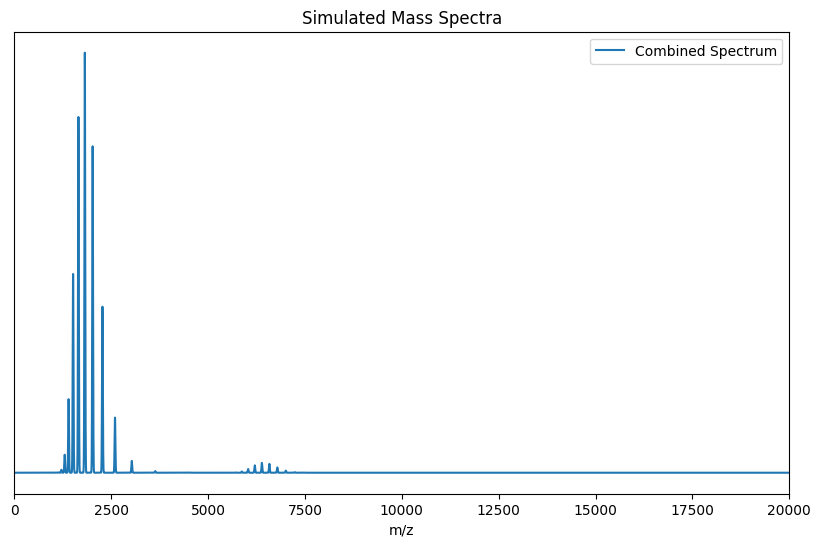

In [53]:
# Monomer masses of Protein A and Protein B
monomer_masses = [210000, 18000]

# Interaction matrix:
# 0, 0 - No proteins
# 1, 0 - Protein A monomer
# 0, 1 - Protein B monomer
# 1, 1 - Heterodimer (Protein A monomer + Protein B monomer)

interaction_matrix = np.array([
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0 , 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0 , 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0 , 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0 , 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0 , 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0 , 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0 , 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0 , 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0 , 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0 , 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0 , 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0 , 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0 , 0, 0, 0]
])

resolution = 1000
chargewidth = 5
maxcharge = 50
noise_level = 0.000
Q = 0.1
F = 1
AO = 1
VA = 1

mz_range, normalized_spectrum = simulate_mass_spectrum(monomer_masses, interaction_matrix, resolution, chargewidth, maxcharge, noise_level, Q, F, AO, VA)

# Plot the simulated spectrum
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(mz_range, normalized_spectrum, label='Combined Spectrum')
plt.xlabel('m/z')
plt.yticks([])  # Remove y-axis tick labels
plt.title('Simulated Mass Spectra')
plt.xlim(0, 20001)
plt.legend()
plt.show()